In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import SSM.ssm as ssm
from SSM.ssm.util import find_permutation
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Generate Data

In [2]:
# Set the parameters of the HMM
time_bins = 200   # number of time bins
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

# Manually tweak the means to make them farther apart
thetas = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
true_hmm.observations.mus = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

In [3]:
# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

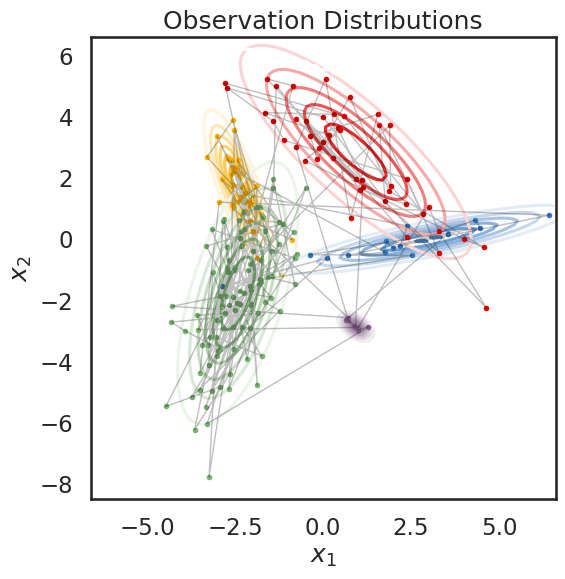

In [4]:
# Plot the observation distributions
lim = .85 * abs(obs).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
input = np.zeros((data.shape[0], 0))
mask = np.ones_like(data, dtype=bool)
tag = None
lls = true_hmm.observations.log_likelihoods(data, input, mask, tag)

plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(obs[true_states==k, 0], obs[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(obs[:,0], obs[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observation Distributions")

plt.show()

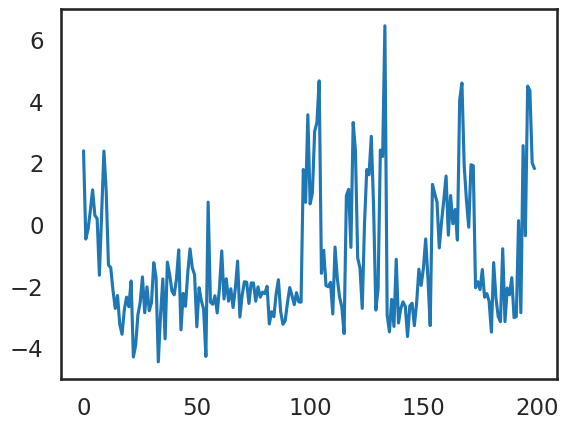

-1.240976151872413


In [5]:
plt.plot(obs[:,0])
plt.show()
print(np.mean(obs[:,0]))

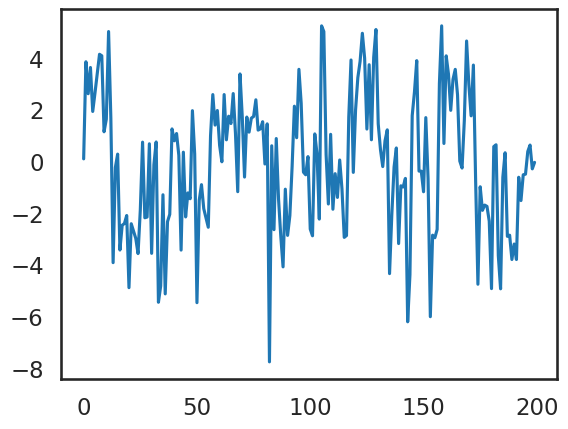

-0.1029562164790278


In [6]:
plt.plot(obs[:,1])
plt.show()
print(np.mean(obs[:,1]))

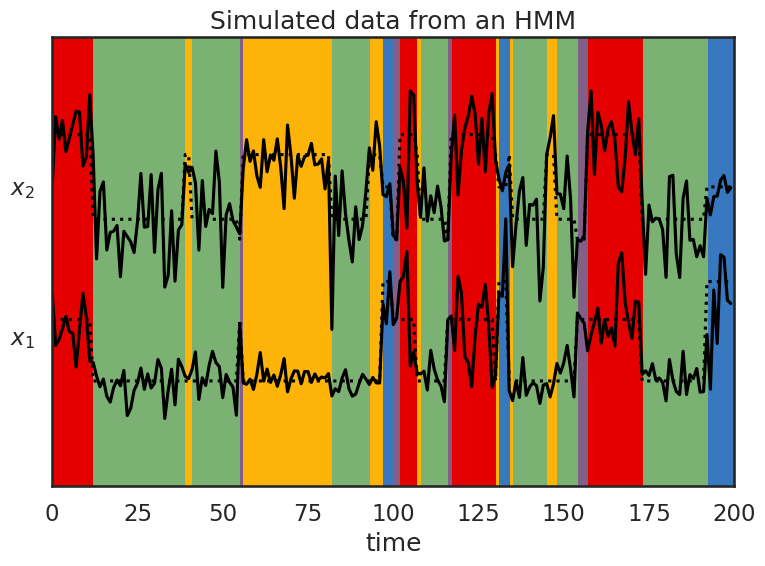

In [7]:
# Plot the data and the smoothed data
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None,:],aspect="auto",cmap=cmap, vmin=0,vmax=len(colors)-1,extent=(0, time_bins, -lim, (obs_dim)*lim))

Ey = true_hmm.observations.mus[true_states]
for d in range(obs_dim):
    plt.plot(obs[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])
plt.title("Simulated data from an HMM")
plt.tight_layout()
plt.show()

In [14]:
np.shape(obs)

(200, 2)

# Fit HMM Model

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

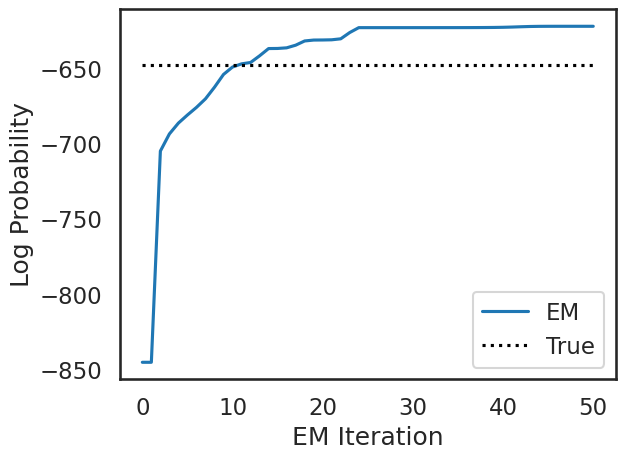

In [8]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 50

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="gaussian")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [9]:
# Find a permutation of the states that best matches the true and inferred states
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

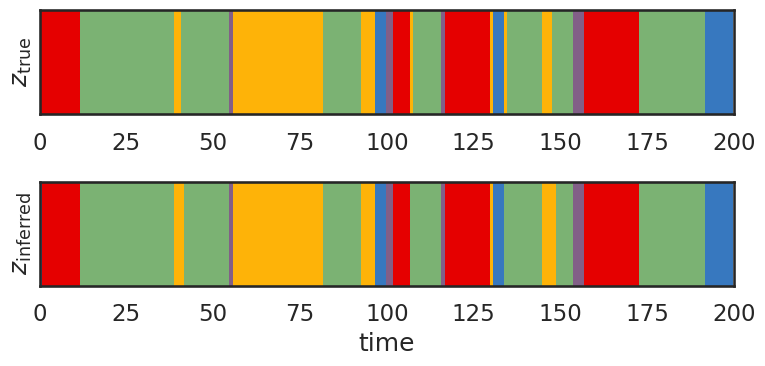

In [10]:
# Plot the true and inferred discrete states
hmm_z = hmm.most_likely_states(data)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

Text(0.5, 0, 'time')

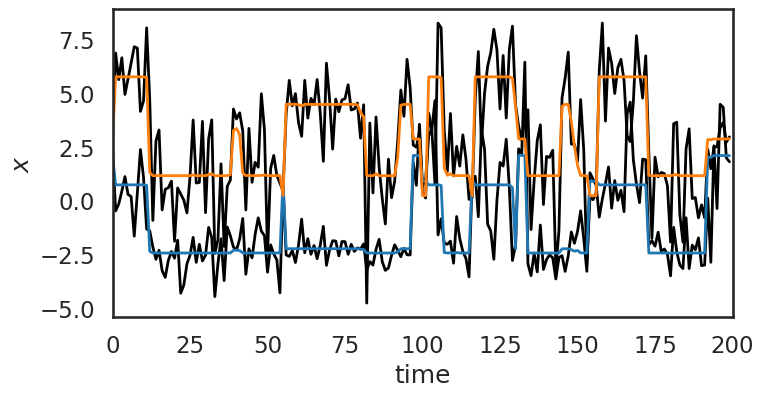

In [11]:
# Use the HMM to "smooth" the data
hmm_x = hmm.smooth(obs)

plt.figure(figsize=(8, 4))
plt.plot(obs + 3 * np.arange(obs_dim), '-k', lw=2)
plt.plot(hmm_x + 3 * np.arange(obs_dim), '-', lw=2)
plt.xlim(0, time_bins)
plt.ylabel("$x$")
# plt.yticks([])
plt.xlabel("time")

# Visualize the Transition Matrices

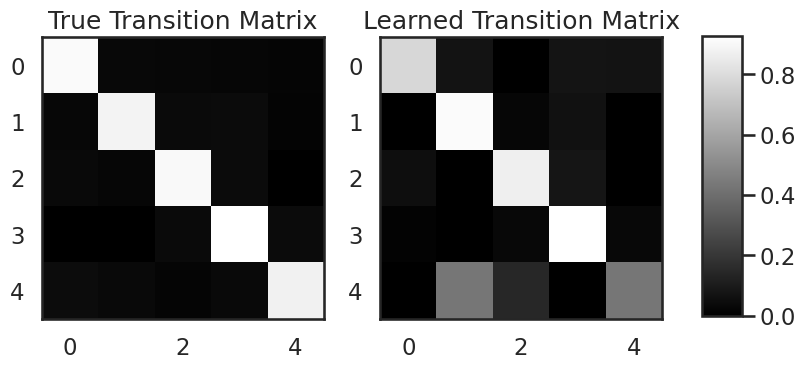

In [12]:
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()
